CS7140

Rajesh Sakhamuru

Zhiyu Chen

# CNN Model for mRNA Degredation Prediction


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import json
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [3]:
def oneHotEncode(rowDict):
    """
    One-hot encode a single sample's sequence data
    """
    categories = ['ACGU', '.()', 'BEHIMSX']

    seq = rowDict['sequence']
    oneHotSeq = np.zeros((len(seq),len(categories[0])))
    for i, char in enumerate(seq):
        oneHotSeq[i, categories[0].index(char)] = 1

    struc = rowDict['structure']
    oneHotStruc = np.zeros((len(struc),len(categories[1])))
    for i, char in enumerate(struc):
        oneHotStruc[i, categories[1].index(char)] = 1

    loop = rowDict['predicted_loop_type']
    oneHotLoop = np.zeros((len(loop),len(categories[2])))
    for i, char in enumerate(loop):
        oneHotLoop[i, categories[2].index(char)] = 1

    return np.hstack([oneHotSeq, oneHotStruc, oneHotLoop])

In [4]:
def encode_timeSteps(idx, oneHotRow, numFeatures):
    """
    Each timestep per one hot encoded row is encoded as just 
    the surrounding characters, and not the entire sequence, so that
    the entire length of the sequence doesn't really matter for predictions
    """
    halfNumFeats = (numFeatures-1)//2
    if idx - halfNumFeats < 0:
        timeStepFeats = oneHotRow[:idx+halfNumFeats+1]
        padding = np.zeros((int(halfNumFeats - idx), timeStepFeats.shape[1]))
        timeStepFeats = np.vstack([padding, timeStepFeats])

    elif idx + halfNumFeats + 1 > len(oneHotRow):
        timeStepFeats = oneHotRow[idx-halfNumFeats:]
        padding = np.zeros((int(halfNumFeats-(len(oneHotRow)-idx))+1, timeStepFeats.shape[1]))
        timeStepFeats = np.vstack([timeStepFeats, padding])
    else:
        timeStepFeats = oneHotRow[idx-halfNumFeats:idx+halfNumFeats+1]
    
    return timeStepFeats

In [5]:
class prepDataset(Dataset):
    """
    Load each one-hot timestep as a separate 'image' tensor, for training CNN
    """
    def __init__(self, path, testFlag=False):
        self.path = path
        self.testFlag = testFlag
        self.features = []
        self.targets = []
        self.ids = []
        self.loadData()
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        if self.testFlag:
            return self.features[idx], self.ids[idx]
        else:
            return self.features[idx], self.targets[idx], self.ids[idx]

    def loadData(self):
        with open(self.path, 'r') as data:
            for row in data:
                rowDict = json.loads(row)
                oneHotRow = oneHotEncode(rowDict)
                
                # Encode each time-step as an 'image' for CNN
                for i in range(rowDict['seq_scored']):
                    timeStepFeats = encode_timeSteps(i, oneHotRow, 21)
                    self.features.append(timeStepFeats)
                    self.ids.append('%s_%d' % (rowDict['id'], i))
                    
                if not self.testFlag:
                    targets = np.stack([rowDict['reactivity'], rowDict['deg_Mg_pH10'], rowDict['deg_Mg_50C']], axis=1)
                    self.targets.extend([targets[i] for i in range(rowDict['seq_scored'])])           

In [6]:
class reactivityModel(nn.Module):
    """
    CNN model with convolution, pooling, dropout and dense layers
    """
    count = 0
    def __init__(self):
        super(reactivityModel, self).__init__()
        self.seqModel = nn.Sequential(
            nn.Conv1d(in_channels=14,out_channels=32,kernel_size=1,stride=1),
            nn.BatchNorm1d(num_features=32),
            nn.PReLU(),
            nn.Conv1d(in_channels=32,out_channels=64,kernel_size=5,stride=1),
            nn.BatchNorm1d(num_features=64),
            nn.PReLU(),
            nn.Conv1d(in_channels=64,out_channels=128,kernel_size=1,stride=1),
            nn.PReLU(),
            nn.MaxPool1d(3, stride=2),
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(1024, 64),
            nn.PReLU(),
            nn.BatchNorm1d(num_features=64),
            nn.Dropout(0.4),
            nn.Linear(64, 64),
            nn.PReLU(),
            nn.BatchNorm1d(num_features=64),
            nn.Dropout(0.5),
            nn.Linear(64, 3)
        )
        
    def forward(self, X):
        return self.seqModel(X)

Output shapes for each layer in the CNN:
```
torch.Size([256, 32, 21])
torch.Size([256, 32, 21])
torch.Size([256, 32, 21])
torch.Size([256, 64, 17])
torch.Size([256, 64, 17])
torch.Size([256, 64, 17])
torch.Size([256, 128, 17])
torch.Size([256, 128, 17])
torch.Size([256, 128, 8])
torch.Size([256, 128, 8])
torch.Size([256, 1024])
torch.Size([256, 64])
torch.Size([256, 64])
torch.Size([256, 64])
torch.Size([256, 64])
torch.Size([256, 64])
torch.Size([256, 64])
torch.Size([256, 64])
torch.Size([256, 64])
torch.Size([256, 3])
```

In [7]:
def trainModel(trainDataLoader, epochs = 25, lr = 0.001, weightsPath = 'drive/MyDrive/Colab Notebooks/CS7140Models/covidCNNModel.pth'):
    """
    Trains the CNN model for specified number of epochs at the specified learning rate.
    """
    model = reactivityModel().cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    lossFunc = nn.MSELoss()
    lossPlot=[]
    for epoch in range(epochs):
        lossList = []
        model.train()
        for features, targets, ids in trainDataLoader:
            features = features.cuda().permute(0,2,1).float()
            targets = targets.cuda().float()
            predictions = model(features)
            loss = lossFunc(predictions, targets)

            for p in model.parameters():
                p.grad = None
            
            loss.backward()
            optimizer.step()
            lossList.append(loss.detach().cpu().numpy())
        
        avg_loss = float(np.mean(lossList))
        print('Epoch:', epoch, 'Loss:', avg_loss)
        lossPlot.append(avg_loss)
    plt.plot(lossPlot)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()
    torch.save(model.state_dict(), weightsPath)

In [8]:
dataFolder = "drive/MyDrive/Colab Notebooks/CS7140 Final Project/stanford-covid/"
testPath = dataFolder + "test.json"
trainPath = dataFolder + "train.json"

In [9]:
trainDataset = prepDataset(trainPath)
trainDataLoader = DataLoader(trainDataset, batch_size=256, shuffle=True, num_workers=4,pin_memory=True)

Epoch: 0 Loss: 0.5735719203948975
Epoch: 1 Loss: 0.4847065210342407
Epoch: 2 Loss: 0.4736497402191162
Epoch: 3 Loss: 0.4690217971801758
Epoch: 4 Loss: 0.46416231989860535
Epoch: 5 Loss: 0.45987468957901
Epoch: 6 Loss: 0.4572766423225403
Epoch: 7 Loss: 0.4553234577178955
Epoch: 8 Loss: 0.45326581597328186
Epoch: 9 Loss: 0.45089051127433777
Epoch: 10 Loss: 0.4496517479419708
Epoch: 11 Loss: 0.4480797350406647
Epoch: 12 Loss: 0.4454289674758911
Epoch: 13 Loss: 0.4456529915332794
Epoch: 14 Loss: 0.4464813470840454


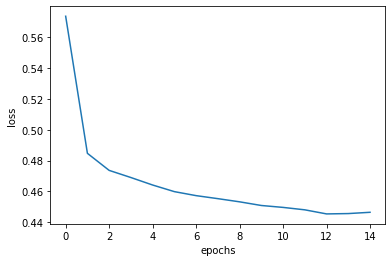

In [12]:
weightsPath = 'drive/MyDrive/Colab Notebooks/CS7140 Final Project/CS7140Models/covidCNNModel.pth'
trainModel(trainDataLoader, epochs=15, lr=0.001, weightsPath=weightsPath)

In [ ]:
testDataset = prepDataset(testPath, testFlag=True)
testDataLoader = DataLoader(testDataset, batch_size=256, num_workers=4, drop_last=False, pin_memory=True)

In [ ]:
for feature,labels,ids in trainDataLoader:
  print(feature.shape)
  print(labels.shape)
  print(len(ids))
  break

torch.Size([256, 21, 14])
torch.Size([256, 3])
256


In [ ]:
sampleSubmPath = dataFolder + "sample_submission.csv"
submissionDF = pd.read_csv(sampleSubmPath, index_col='id_seqpos')

model = reactivityModel().cuda()
model.load_state_dict(torch.load(weightsPath))
model.eval()
for testFeats, ids in testDataLoader:
    testFeats = testFeats.cuda().permute(0,2,1).float()
    preds = model(testFeats)
    submissionDF.loc[ids,['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C']] = preds.detach().cpu().numpy()
submissionDF[['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C']].head()

,reactivity,deg_Mg_pH10,deg_Mg_50C
id_seqpos,,,
id_00073f8be_0,0.608023,0.579971,0.539257
id_00073f8be_1,2.088875,3.104047,3.034355
id_00073f8be_2,1.210173,0.753603,0.899748
id_00073f8be_3,1.254127,0.964447,1.197333
id_00073f8be_4,0.657128,0.652678,0.705029


In [ ]:
submissionDF.to_csv(dataFolder+'CNNSubmission.csv')

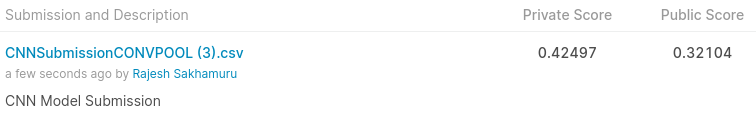

This submission would rank 1487 out of 1636 total submissions to the actual competition. CNN is not a very good method for predicting sequence data, so the results were not competitive, but did manage to do better than a reasonable number of official submissions made during the actual competition.

The scores are based on MCRMSE (mean columnwise root mean squared error). The score which matters is the 'Public Score' which can be compared against other Kaggle user submissions from the actual competition.